In [71]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [72]:
df = pd.read_csv('data/data_final_preprocessed.csv')


In [73]:
df

,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,child_amt,...,emp_citizenship_country_cd,emp_marital_status_cd,day_of_week,holiday_flg,million_city,child_flg,success_flg,product,function,pro_flg
0,342841087,40.0,0.0,town,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,4,0,0.0,1,0,Кредит,Входящие звонки,0
1,104017416,30.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6,1,NaN,0,0,Кредитная карта,Подготовка и одобрение,0
2,579880064,65.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4,0,NaN,0,0,Кредитная карта,Подготовка и одобрение,0
3,124379737,28.0,1.0,msk,0.0,0.0,1.0,0.0,1.0,1.0,...,NaN,NaN,4,0,1.0,1,0,Кредитная карта,Подготовка и одобрение,0
4,505902204,19.0,1.0,town,0.0,0.0,0.0,0.0,0.0,0.0,...,Россия,Холост/не замужем,0,0,0.0,0,1,Кредитная карта,Активация и автоматизация,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12225,139422099,31.0,0.0,town,0.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,1,0,0.0,0,0,Кредитная карта,Подготовка и одобрение,0
12226,265874391,48.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,0,NaN,0,0,Кредит,Подготовка и одобрение,0
12227,305282509,39.0,0.0,urban,0.0,1.0,0.0,0.0,1.0,2.0,...,NaN,NaN,3,0,1.0,1,1,Кредитная карта,Подготовка и одобрение,0
12228,191420290,48.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,0,NaN,0,0,Кредитная карта,Подготовка и одобрение,0


In [51]:
df = pd.read_csv('data/data_final_preprocessed.csv')

X = df[['pro_flg', 'age', 'gender_cd', 'state_talk_time_sec']]
y = df['success_flg']

model = sm.Logit(y, X)
model_result = model.fit()

print(model_result.summary())

Optimization terminated successfully.
         Current function value: 0.389054
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            success_flg   No. Observations:                15080
Model:                          Logit   Df Residuals:                    15076
Method:                           MLE   Df Model:                            3
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                 -0.3691
Time:                        20:54:55   Log-Likelihood:                -5866.9
converged:                       True   LL-Null:                       -4285.4
Covariance Type:            nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
pro_flg                -2.0871      0.073    -28.732      0.000      -2.229      -1.945
ag

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df['success_flg'], model_result.predict())

np.float64(0.8105509084060973)

In [25]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the data
df = pd.read_csv('data/data_final_preprocessed.csv')

# Define features and target
X = df[['pro_flg', 'age', 'state_talk_time_sec']]
y = df['success_flg']

# Add constant to the features
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model
model = sm.Logit(y_train, X_train)
model_result = model.fit()

# Predict probabilities on the test set
y_pred_prob = model_result.predict(X_test)

# Convert probabilities to binary labels using a threshold of 0.5
y_pred = (y_pred_prob > 0.3).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred))

Optimization terminated successfully.
         Current function value: 0.218326
         Iterations 7
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4151
           1       0.35      0.33      0.34       373

    accuracy                           0.89      4524
   macro avg       0.65      0.64      0.64      4524
weighted avg       0.89      0.89      0.89      4524



In [21]:
from imblearn.over_sampling import RandomOverSampler
df = pd.read_csv('data/data_final_preprocessed.csv')

# Define features and target
X = df[['pro_flg', 'age', 'state_talk_time_sec', 'gender_cd', '']]
y = df['success_flg']

# Add constant to the features
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Пример балансировки данных
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Переобучение модели на сбалансированных данных
model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled))
model_result = model.fit()
print(model_result.summary())

Optimization terminated successfully.
         Current function value: 0.473897
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            success_flg   No. Observations:                19378
Model:                          Logit   Df Residuals:                    19373
Method:                           MLE   Df Model:                            4
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.3163
Time:                        18:28:48   Log-Likelihood:                -9183.2
converged:                       True   LL-Null:                       -13432.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.6112      0.029    -20.959      0.000      -0.668      -0.554
pr

In [22]:
y_pred_prob = model_result.predict(X_test)

# Convert probabilities to binary labels using a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      4151
           1       0.25      0.73      0.37       373

    accuracy                           0.80      4524
   macro avg       0.61      0.77      0.63      4524
weighted avg       0.91      0.80      0.84      4524



In [111]:
df = pd.read_csv('data\data_final_preprocessed.csv')
X = df[['pro_flg', 'age', 'state_talk_time_sec']]
y = df['success_flg']
X = sm.add_constant(X)

model = sm.Logit(y, X)
model_fit = model.fit()

X_test = df_test_msk[['pro_flg', 'age', 'state_talk_time_sec']]
y_test_msk = df_test_msk['success_flg']
X_test_msk = sm.add_constant(X_test_msk)
y_pred_msk = model_fit.predict(X_test_msk)
y_pred_msk
from sklearn.metrics import classification_report
print(classification_report(y_test_msk, y_pred_msk))

Optimization terminated successfully.
         Current function value: 0.220324
         Iterations 7


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [74]:
# список для хранения результатов тестирования
results = []
df = pd.read_csv('data\data_final_preprocessed.csv')
# Группировка данных по продуктам
for product, group in df.groupby('product'):
    contingency_table = pd.crosstab(group['bundle_nm'], group['success_flg'])

    # Проверка, достаточно ли данных для проведения теста
    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        # Если данных недостаточно, добавляем результат с указанием на отсутствие данных
        results.append({
            'product': product,
            'test': 'Нет данных',
            'p_value': None,
            'significant': None
        })
        continue

    # Проверка на минимальное значение в контингентной таблице
    if contingency_table.values.min() < 5:
        # Если минимальное значение меньше 5, используем тест Фишера
        stat, p_value = stats.fisher_exact(contingency_table, alternative='two-sided')
        test_type = 'Fisher'  # Указываем тип теста
    else:
        # В противном случае используем критерий хи-квадрат
        stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
        test_type = 'Chi2'  # Указываем тип теста

    # Добавление результатов теста в список
    results.append({
        'product': product,
        'test': test_type,
        'p_value': p_value,
        'significant': p_value < 0.05  # Определяем, является ли результат статистически значимым
    })

results_df = pd.DataFrame(results)

results_df


,product,test,p_value,significant
0,Дебетовая карта,Chi2,0.000001,True
1,Инвестиции,Fisher,0.086281,False
2,Кредит,Chi2,0.543609,False
3,Кредитная карта,Chi2,0.501329,False
4,Страхование и услуги,Chi2,0.516177,False


In [9]:
df = pd.read_csv('data\data_final_preprocessed.csv')
df['pro_flg'] = df['pro_flg'].map({1: 1, 0: -1})
for col in df['product'].unique():
    df1 = df[df['product'] == col]
    X = df1[['pro_flg', 'age', 'state_talk_time_sec']]
    y = df1['success_flg']
    X = sm.add_constant(X)
    print(f'----------------------------{col}----------------------------')
    model = sm.Logit(y, X)
    model_result = model.fit()
    print(model_result.summary())

----------------------------Кредит----------------------------
Optimization terminated successfully.
         Current function value: 0.113101
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            success_flg   No. Observations:                 2612
Model:                          Logit   Df Residuals:                     2608
Method:                           MLE   Df Model:                            3
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.3142
Time:                        08:33:50   Log-Likelihood:                -295.42
converged:                       True   LL-Null:                       -430.76
Covariance Type:            nonrobust   LLR p-value:                 2.204e-58
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.7

In [196]:
df = pd.read_csv('data\data_final_preprocessed.csv')
X = df[['pro_flg', 'state_talk_time_sec', 'age']]
y = df['success_flg']
X = sm.add_constant(X)

model = sm.Logit(y, X)
model_result = model.fit()

print(model_result.summary())

Optimization terminated successfully.
         Current function value: 0.220324
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            success_flg   No. Observations:                15080
Model:                          Logit   Df Residuals:                    15076
Method:                           MLE   Df Model:                            3
Date:                Fri, 13 Dec 2024   Pseudo R-squ.:                  0.2247
Time:                        22:13:55   Log-Likelihood:                -3322.5
converged:                       True   LL-Null:                       -4285.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.9463      0.046    -63.621      0.000      -3.037      -2.856
pr

In [197]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df['success_flg'], model_result.predict())

np.float64(0.8619338523214619)

In [198]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data

,feature,VIF
0,const,1.309563
1,pro_flg,1.012126
2,state_talk_time_sec,1.003632
3,age,1.012515


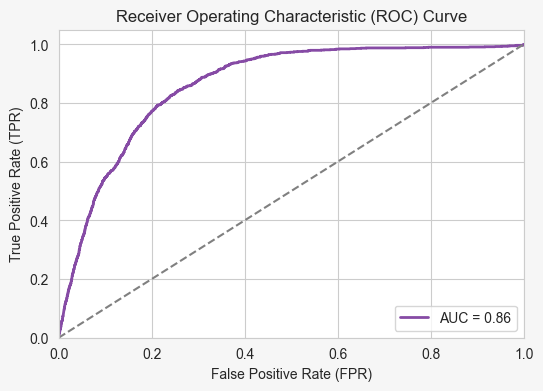

In [199]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities from the probit model
y_pred_prob = model_result.predict(X)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")  # Настройка стиля фона

# Устанавливаем цвет фона
plt.gcf().set_facecolor('#F6F6F6')
plt.plot(fpr, tpr, color='#864BA5', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [86]:
df = pd.read_csv('data\data_final_preprocessed.csv')
values = df.region_size.value_counts().reset_index()
values

,region_size,count
0,town,4754
1,urban,2119
2,msk,1242
3,rural,841


<Axes: xlabel='region_size', ylabel='count'>

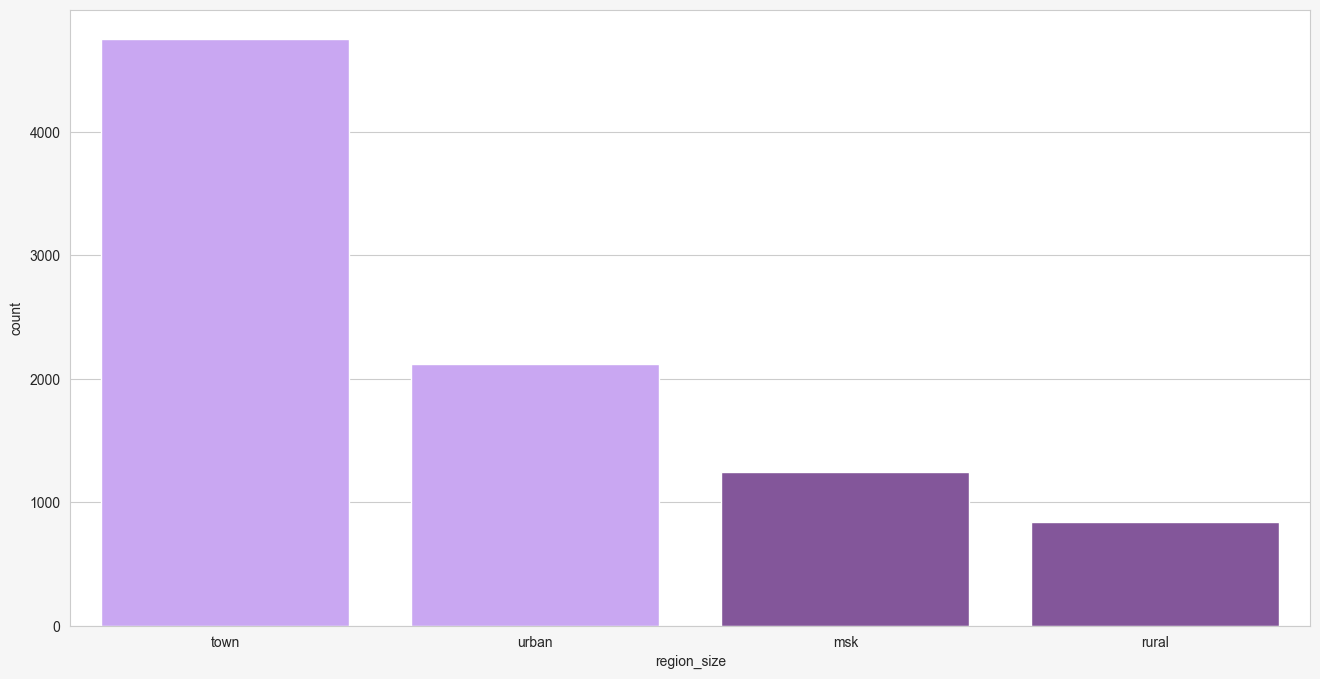

In [92]:
plt.figure(figsize=(16, 8))

sns.set_style("whitegrid")
plt.gcf().set_facecolor('#F6F6F6')

sns.barplot(data=values, x='region_size', y='count', palette=['#C89AFF', '#C89AFF', '#864BA5', '#864BA5'])
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.show()

<Axes: >

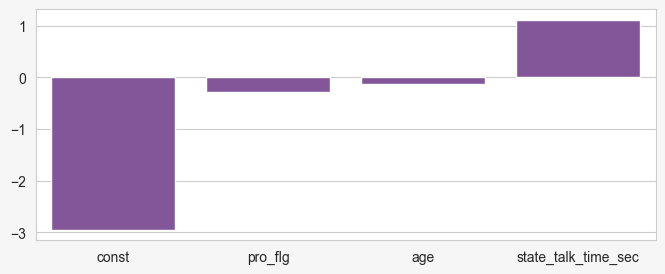

In [65]:
plt.figure(figsize=(8, 3))
sns.set_style("whitegrid")  # Настройка стиля фона

names = ['const', 'pro_flg', 'age', 'state_talk_time_sec']
coefs = [-2.95, -0.29, -0.12, 1.12]

# Устанавливаем цвет фона
plt.gcf().set_facecolor('#F6F6F6')
sns.barplot(x=names, y=coefs, color='#864BA5')

In [52]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv('data/data_final_preprocessed.csv')

X = df[['pro_flg', 'age', 'state_talk_time_sec']]
y = df['success_flg']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.Logit(y_train, X_train)

model_result = model.fit()

print(model_result.summary())

y_pred_prob = model_result.predict(X_test)

threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")


Optimization terminated successfully.
         Current function value: 0.219432
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            success_flg   No. Observations:                12064
Model:                          Logit   Df Residuals:                    12060
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Dec 2024   Pseudo R-squ.:                  0.2278
Time:                        13:20:55   Log-Likelihood:                -2647.2
converged:                       True   LL-Null:                       -3428.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.9349      0.052    -56.818      0.000      -3.036      -2.834
pr

In [59]:
df = pd.read_csv('data\data_final_preprocessed.csv')
df.dropna(subset=['region_size'], inplace=True)
for col in df['region_size'].unique():
    df1 = df[df['region_size'] == col]
    X = df1[['pro_flg', 'age', 'state_talk_time_sec']]
    y = df1['success_flg']
    X = sm.add_constant(X)
    print(f'---------------------------------------------------------------------------------------')
    print(f'-----------------------------------------{col}-----------------------------------------')
    print(f'---------------------------------------------------------------------------------------')
    model = sm.Logit(y, X)
    model_result = model.fit()
    print(model_result.summary())

---------------------------------------------------------------------------------------
-----------------------------------------town-----------------------------------------
---------------------------------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.251866
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            success_flg   No. Observations:                 4754
Model:                          Logit   Df Residuals:                     4750
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Dec 2024   Pseudo R-squ.:                  0.2226
Time:                        16:15:28   Log-Likelihood:                -1197.4
converged:                       True   LL-Null:                       -1540.2
Covariance Type:            nonrobust   LLR p-value:                2.803e-148
   

----------------------------town----------------------------
Optimization terminated successfully.
         Current function value: 0.251866
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            success_flg   No. Observations:                 4754
Model:                          Logit   Df Residuals:                     4750
Method:                           MLE   Df Model:                            3
Date:                Fri, 13 Dec 2024   Pseudo R-squ.:                  0.2226
Time:                        16:37:35   Log-Likelihood:                -1197.4
converged:                       True   LL-Null:                       -1540.2
Covariance Type:            nonrobust   LLR p-value:                2.803e-148
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.742

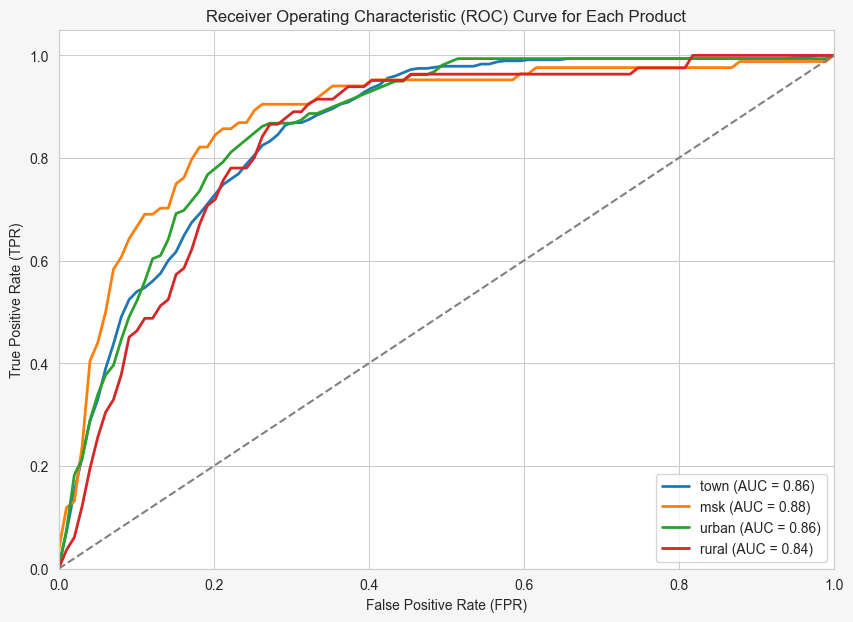

In [93]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod import families
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# Загрузка данных
df = pd.read_csv('data/data_final_preprocessed.csv')

# Создаем словарь для хранения результатов по каждому продукту
roc_data = {}

df.dropna(subset=['region_size'], inplace=True)

# Проходим по каждому уникальному продукту
for col in df['region_size'].unique():
    df1 = df[df['region_size'] == col]
    X = df1[['pro_flg', 'age', 'state_talk_time_sec']]
    y = df1['success_flg']
    X = sm.add_constant(X)

    print(f'----------------------------{col}----------------------------')
    model = sm.Logit(y, X)
    model_result = model.fit()
    print(model_result.summary())

    # Получаем предсказанные вероятности
    y_pred_prob = model_result.predict(X)

    # Вычисляем ROC-кривую и AUC
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Сохраняем результаты для текущего продукта
    roc_data[col] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

# Построение ROC-кривых для всех продуктов на одном графике
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")  # Настройка стиля фона

# Устанавливаем цвет фона
plt.gcf().set_facecolor('#F6F6F6')

# Проходим по всем продуктам и строим их ROC-кривые
for product, data in roc_data.items():
    # Интерполяция для сглаживания кривой
    fpr_smooth = np.linspace(0, 1, 100)
    tpr_smooth = interp1d(data['fpr'], data['tpr'], kind='linear')(fpr_smooth)

    plt.plot(fpr_smooth, tpr_smooth, label=f'{product} (AUC = {data["auc"]:.2f})', lw=2)

# Добавляем диагональную линию (случайное угадывание)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Настройка графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Product')
plt.legend(loc='lower right')
plt.show()